In this notebook, we simulate rainfall-runoff in the Cauquenes catchment using:

1- GR4J: The simulation was done in R and exported here for ploting.

2- HyMoLAP: We calibrate and validate the HyMoLAP model here.

3- GR4-HyMoLAP: We calculate the percolation using the GR4 framework, that we then incoporate in HyMoLAP framework. The calibration method as described in the paper, is the same we used for HyMoLAP model.

4- GR4-HyMoLAP-SVR: We train and test the GR4-HyMoLAP-SVR model using different kernels, with the RBF giving the best perfromance.

In [1]:
#Librairies
import pandas as pd
from matplotlib import pylab as plt
from datetime import datetime
import numpy as np
import math
import random
from numpy import concatenate
from pandas import read_csv
from datetime import datetime, timedelta

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, KFold, RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import joblib
import matplotlib.dates as mdates
from google.colab import files

In [2]:
#Connection to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Data

daily = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Alone/Cauquenes7336001__.csv')

daily.head()

,P_mm,Tmx_degC,Tmn_degC,PET_mm,Qobs_mm,Qobs_m3s,Date
0,0.0,24.923411,11.023331,5.541,0.130969,0.943,1979-01-01
1,0.0,26.041955,11.184346,5.827,0.120553,0.868,1979-01-02
2,0.0,27.163775,11.941578,6.044,0.118886,0.856,1979-01-03
3,0.0,27.528073,12.264598,6.100,0.109442,0.788,1979-01-04
4,0.0,26.982496,12.659137,5.890,0.108331,0.780,1979-01-05


In [4]:
#Check missing values
np.where(np.isnan(daily.iloc[:, 5].to_numpy()))

(array([   88,    89,   882,   912,  1351,  1629,  1648,  2011,  2716,
         4415,  4420,  4564,  4575,  4586,  4594,  4974,  4975,  4976,
         4977,  4978,  4979,  4980,  4981,  4982,  4983,  4984,  4985,
         4986,  4987,  4988,  4989,  4990,  4991,  4992,  4993,  4994,
         4995,  4996,  4997,  4998,  4999,  5000,  5001,  5002,  5003,
         5004,  5005,  5006,  5007,  5008,  5009,  5010,  5011,  5012,
         5013,  5903,  5904,  5905,  5906,  5907,  5908,  5949,  5950,
         5951,  5952,  5953,  5954,  5955,  5956,  5957,  5958,  5959,
         5960,  5961,  5962,  5963,  5964,  5965,  5966,  5967,  5968,
         5969,  5970,  5971,  5972,  5973,  5974,  5995,  5996,  5997,
         5998,  5999,  6000,  6001,  6002,  6003,  6004,  6005,  6006,
         6012,  6013,  6014,  6015,  6016,  6017,  6018,  6019,  6020,
         6021,  6022,  6023,  6024,  6025,  6026,  6027,  6028,  6029,
         6030,  6031,  6032,  6033,  6034,  6035,  7234,  7250,  7251,
      

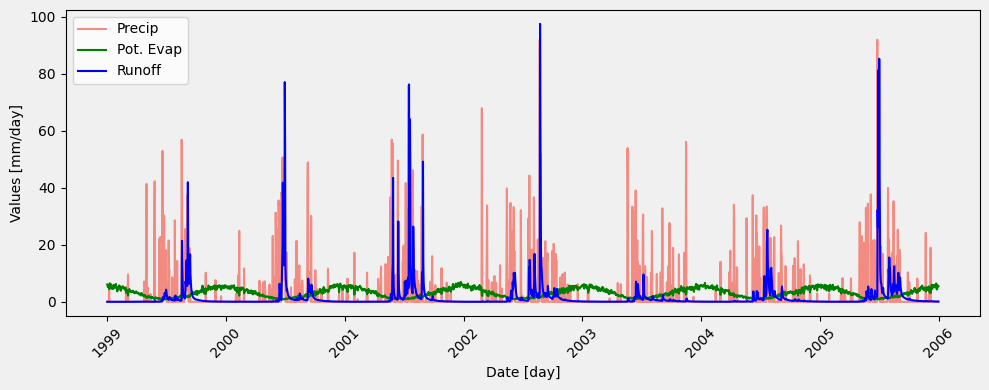

In [5]:
plt.figure(figsize=(10, 4))
fig = plt.gcf()  # Get current figure
fig.patch.set_facecolor('#f0f0f0')  # Figure background color

# Create an axis
ax = plt.gca()
ax.set_facecolor('#f0f0f0')  # Axis background color

# Different colors for each variable
colors = {
    "pluie": "#f28b82",
    "etp": "green",
    "debit": "blue"
}

# Custom names for the legend
legend_labels = {
    "pluie": "Precip",
    "etp": "Pot. Evap",
    "debit": "Runoff"
}

# Analysis period
start_date = '1999-01-01'
end_date = '2005-12-31'
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Create the DataFrame
dailyy = pd.DataFrame({
    'pluie': daily["P_mm"].values[7305:9862],
    'etp': daily["PET_mm"].values[7305:9862],
    'debit': daily["Qobs_mm"].values[7305:9862]
}, index=date_range)

# Variables to plot
ordered_vars = ["pluie", "etp", "debit"]

# Ticks for the X axis
start_year = 1999
end_year = 2006
years = list(range(start_year, end_year + 1))
ticks = pd.to_datetime([f'{year}-01-01' for year in years])

# Plot the three series on the same plot
for var in ordered_vars:
    ax.plot(dailyy.index, dailyy[var], label=legend_labels[var], color=colors[var])

plt.xlabel('Date [day]')
plt.ylabel('Values [mm/day]')
plt.legend()

plt.xticks(ticks=ticks, labels=[tick.year for tick in ticks], rotation=45)

plt.tight_layout()

# Save figure
plt.savefig("Cauquenes.jpeg", format='jpeg', dpi=700)

#files.download("Cauquenes.jpeg")

plt.show()


In [6]:
#Calibration data
discharge = daily.iloc[7305:8766, 4].to_numpy()
plui = daily.iloc[7305:8766, 0].to_numpy() #Precipitation
etp = daily.iloc[7305:8766, 3].to_numpy() #PET

#Validation data
discharge1 = daily.iloc[8766:9862, 4].to_numpy()
plui1 = daily.iloc[8766:9862, 0].to_numpy()
etp1 = daily.iloc[8766:9862, 3].to_numpy()

In [7]:
discharge[-1]

np.float64(0.144440946928719)

In [8]:
discharge1[-1]

np.float64(0.101386433901889)

In [9]:
#NSE, RMSE, R2
def nash_sutcliffe_efficiency(observed, simulated):
    obs_mean = np.mean(observed)
    numerator = np.sum((observed - simulated) ** 2)
    denominator = np.sum((observed - obs_mean) ** 2)

    nse = 1 - (numerator / denominator)
    return nse

def calculate_rmse(observed, predicted):

    rmse = np.sqrt(np.mean((observed - predicted)**2))
    return rmse

def calculate_r2(observed, predicted):

    mean_observed = np.mean(observed)
    mean_predicted = np.mean(predicted)

    numerator = np.sum((observed - mean_observed) * (predicted - mean_predicted))
    denominator = np.sqrt(np.sum((observed - mean_observed)**2)) * np.sqrt(np.sum((predicted - mean_predicted)**2))

    r2 = (numerator / denominator)**2
    return r2


GR4J

We import the GR4J simulation results from R

In [10]:
GR4J = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Alone/GR4J_cal_Cauqueness.xlsx')
GR4J_val = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Alone/GR4J_vali_Cauqueness.xlsx')

simGR4J = GR4J.to_numpy()
simGR4J_val = GR4J_val.to_numpy()

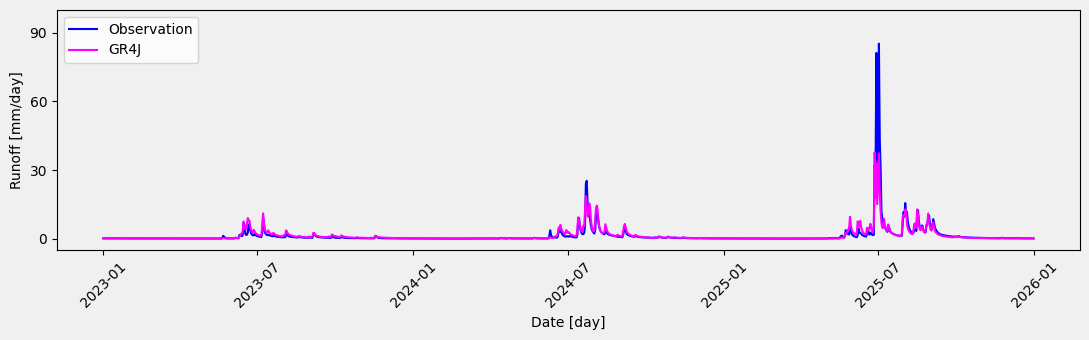

In [11]:
# Generate dates
time1 = np.datetime64('2023-01-01')
time2 = np.datetime64('2025-12-31')
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create figure and axis
fig, ax = plt.subplots(figsize=(11., 3.5))

# Background color
fig.patch.set_facecolor('#f0f0f0')
ax.set_facecolor('#f0f0f0')

# Plot observed and simulated discharge
ax.plot(time, discharge1, 'b',  label='Observation', linewidth=1.5)
ax.plot(time, simGR4J_val, 'magenta', label='GR4J', linewidth=1.5)

# X-axis parameters (date format)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 7]))
plt.xticks(rotation=45)
ax.set_xlabel('Date [day]')

# Y-axis parameters
ax.set_ylabel('Runoff [mm/day]')
ax.tick_params(axis='y', labelcolor='black')
ax.set_ylim(-5, 100)
ax.set_yticks(np.arange(0, 101, 30))

# Add legend
ax.legend(loc='upper left')

# Show grid
# plt.grid(True)

# Avoid overlaps
plt.tight_layout()

# Save figure
plt.savefig("Cauqueness_GR4J.jpeg", format='jpeg', dpi=700)

#files.download("Cauqueness_GR4J.jpeg")

# Show plot
plt.show()


In [12]:
#Calibration
simGR4J = simGR4J.flatten()
print('nashe=',nash_sutcliffe_efficiency(discharge[1:], simGR4J[1:]))
print('rmse=',calculate_rmse(discharge[1:], simGR4J[1:]))
print('r2=',calculate_r2(discharge[1:], simGR4J[1:]))

nashe= 0.7545320895464633
rmse= 3.096089622463731
r2= 0.7731960281575434


In [13]:
#Validation
simGR4J_val = simGR4J_val.flatten()
print('nashe=',nash_sutcliffe_efficiency(discharge1[1:], simGR4J_val[1:]))
print('rmse=',calculate_rmse(discharge1[1:], simGR4J_val[1:]))
print('r2=',calculate_r2(discharge1[1:], simGR4J_val[1:]))

nashe= 0.7190146300372414
rmse= 2.48712525352491
r2= 0.7647773700508799


HyMoLAP

In [14]:
#State of the basin X(t)
def state_soil(MU, LANDA, q):
    n = len(q)
    X = np.zeros(n)
    X[0] = q[0]
    for i in range(1, n):
        if q[i] == 0:
            X[i] = X[i - 1] - (MU / LANDA) * X[i - 1]
        else:
            X[i] = X[i - 1] + (MU / LANDA) * q[i]
    return X

In [15]:
#Compute the Effective precipitation
Pn = plui - etp
Pn[Pn < 0] = 0

#  model
nse = -100
Qsim = np.zeros(len(discharge))
Qsim[0] = discharge[0]

for pp in range(20000):
      mu = (1.7 - 1) * np.random.rand() + 1
      lambda_ = (70 - 5) * np.random.rand() + 5

      Xt = state_soil(mu, lambda_, Pn)

      for k in range(len(discharge)-1):

          Qsim[k+1] = Qsim[k] - (mu/lambda_) * Qsim[k]**(2*mu-1) +  (1/lambda_) * Xt[k] * Pn[k]


      #Nsh criteria
      nsee =  nash_sutcliffe_efficiency(discharge[1:], Qsim[1:])
      if nsee > nse:
          nse = nsee
          mu1 = mu
          lambda1 = lambda_
          Q_HyMoLAP = Qsim.copy()


print(nse)

<ipython-input-15-aac2dae34810>:18: RuntimeWarning: invalid value encountered in scalar power
  Qsim[k+1] = Qsim[k] - (mu/lambda_) * Qsim[k]**(2*mu-1) +  (1/lambda_) * Xt[k] * Pn[k]


0.590676095274868


In [16]:
print(mu1)
print(lambda1)

1.3991653601981457
36.15006431760921


In [17]:
#Consider only the best case of NSE
print('nashe=',nash_sutcliffe_efficiency(discharge[1:], Q_HyMoLAP[1:]))
print('rmse=',calculate_rmse(discharge[1:], Q_HyMoLAP[1:]))
print('r2=',calculate_r2(discharge[1:], Q_HyMoLAP[1:]))

nashe= 0.590676095274868
rmse= 3.9980637528481116
r2= 0.6366236189999716


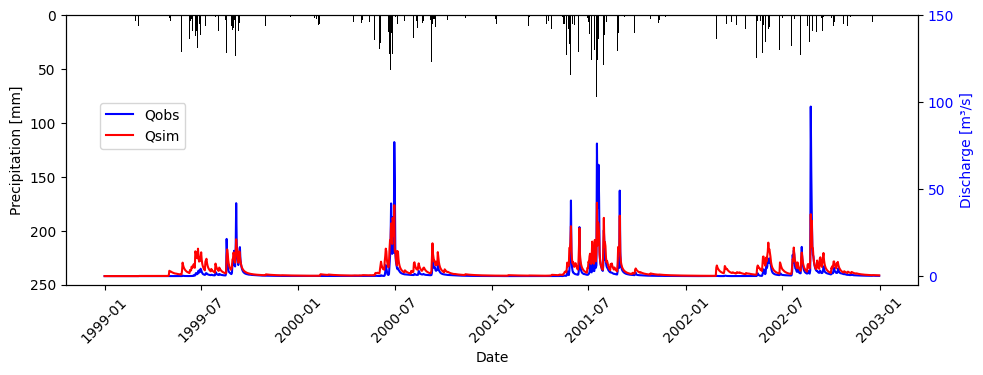

In [18]:
# Create a date range from '01-01-1999' to '12-31-2002'
time1 = np.datetime64('1999-01-01')
time2 = np.datetime64('2002-12-31')
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create a figure and axes with a reduced figure size
fig, ax1 = plt.subplots(figsize=(11., 3.5))

# Plot a histogram for precipitation on the ax1 axes
ax1.bar(time, plui, color='black')

# Format x-axis labels
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

ax1.set_xlabel('Date')

# Y-axis settings for precipitation
ax1.set_ylabel('Precipitation [mm]', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(0, 250)
ax1.set_yticks(np.arange(0, 251, 50))

# Invert the y-axis and place ticks on the left for precipitation
ax1.invert_yaxis()
ax1.yaxis.set_label_position("left")

# Create a second y-axis to plot discharges
ax2 = ax1.twinx()
ax2.plot(time, discharge, 'b', label='Qobs')

# Plot min, max and mean values as a confidence interval region
#ax2.fill_between(time, min_trajectory, max_trajectory, color='gray', alpha=0.3, label='95% CrI')

# Plot the mean trajectories
ax2.plot(time, Q_HyMoLAP, 'red', label='Qsim')

# Y-axis settings for daily discharges
ax2.set_ylabel('Discharge [m³/s]', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(-5, 150)
ax2.set_yticks(np.arange(0, 151, 50))

# Add a legend inside the plot
fig.legend(loc='upper left', bbox_to_anchor=(0.15, 0.65))

# Display the grid
#plt.grid(True)

# Show the plot
plt.show()


validation

In [19]:
Pn1 = plui1 - etp1
Pn1[Pn1 < 0] = 0

In [20]:
#validation
size = len(discharge1)
Xt1 = state_soil(mu1, lambda1, Pn1)

Qval_HyM = np.zeros(size)
Qval_HyM[0] = discharge1[0]
for k in range(size-1):

    Qval_HyM[k+1] = Qval_HyM[k] - (mu1/lambda1) * Qval_HyM[k]**(2*mu1-1) +  (1/lambda1) * Xt1[k] * Pn1[k]

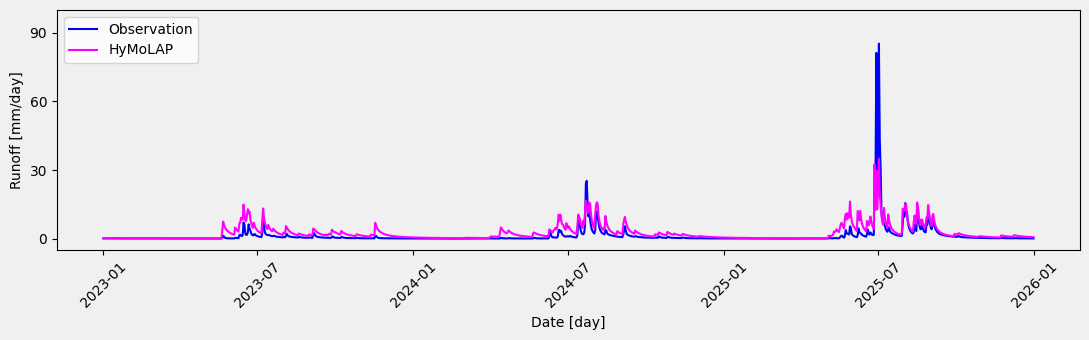

In [21]:
# Generate dates
time1 = np.datetime64('2023-01-01')
time2 = np.datetime64('2025-12-31')
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create a figure and an axis
fig, ax = plt.subplots(figsize=(11., 3.5))

# Background color
fig.patch.set_facecolor('#f0f0f0')
ax.set_facecolor('#f0f0f0')

# Plot observed and simulated discharges
ax.plot(time, discharge1, 'b',  label='Observation', linewidth=1.5)
ax.plot(time, Qval_HyM, 'magenta', label='HyMoLAP', linewidth=1.5)

# X-axis settings (date format)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 7]))
plt.xticks(rotation=45)
ax.set_xlabel('Date [day]')

# Y-axis settings
ax.set_ylabel('Runoff [mm/day]')
ax.tick_params(axis='y', labelcolor='black')
ax.set_ylim(-5, 100)
ax.set_yticks(np.arange(0, 101, 30))

# Add legend
ax.legend(loc='upper left')

# Show grid
#plt.grid(True)

# Avoid overlaps
plt.tight_layout()

# Save figure
plt.savefig("Cauqueness_HyMoLAP.jpeg", format='jpeg', dpi=700)

#files.download("Cauqueness_HyMoLAP.jpeg")

# Display
plt.show()


In [22]:
nse_value = nash_sutcliffe_efficiency(discharge1[1:], Qval_HyM[1:])
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

rmse = calculate_rmse(discharge1[1:], Qval_HyM[1:])
print('rmse=', rmse)

r2 = calculate_r2(discharge1[1:], Qval_HyM[1:])
print('r2=', r2)

Nash-Sutcliffe Efficiency (NSE): 0.5109183799587402
rmse= 3.2813040473843946
r2= 0.5785439731754971


GR4J_HyMoLAP

In [23]:
#Percolation

def Percolation(Pn, En, X1):
   n = len(Pn)
   S = np.zeros(n)
   S[0] =  Pn[0]

   Perc = np.zeros(n)
   ratio = (4.0 / 9.0) * (S[0] / X1)
   Perc[0] = S[0] * (1 - (1 + ratio**4) ** (-0.25))

   Pr = np.zeros(n)
   Pr[0] = Perc[0] + Pn[0]

   for i in range(1, n):
        temp = (S[i-1] / X1) ** 2
        frac = Pn[i] / X1
        Ps = X1 * (1 - temp) * np.tanh(frac) / (1 + (S[i-1] / X1) * np.tanh(frac))

        frac = En[i] / X1
        Es = S[i-1] * (2 - S[i-1] / X1) * np.tanh(frac) / (1 + (1 - S[i-1] / X1) * np.tanh(frac))

        S[i] = S[i-1] + Ps - Es

        ratio = (4.0 / 9.0) * (S[i] / X1)
        Perc[i] = S[i] * (1 - (1 + ratio**4) ** (-0.25))

        Pr[i] = Perc[i] + Pn[i] - Ps

   return Perc

In [24]:
#Calibration

En = etp - plui
En[En < 0] = 0

#  model
nse = -100
Qsim = np.zeros(len(discharge))
Qsim[0] = discharge[0]
Q1 = np.zeros(len(discharge))

for pp in range(1): #range(20000):
      mu = 1.0876190199933156 #(1.5 - 0.7) * np.random.rand() + 0.7
      lambda_ = 3.7565491745434856 #(10 - 0.1) * np.random.rand() + 0.1
      X1 = 291.8694529794576 #(350 - 250) * np.random.rand() + 250

      Perc = Percolation(Pn, En, X1)

      for k in range(len(discharge)-1):

          Qsim[k+1] = Qsim[k] - (mu/lambda_) * Qsim[k]**(2*mu-1) +  (1/lambda_) * Perc[k] * Pn[k]


      #Nsh criteria
      nsee =  nash_sutcliffe_efficiency(discharge[1:], Qsim[1:])
      if nsee > nse:
          nse = nsee
          mu1 = mu
          lambda1 = lambda_
          X11 = X1
          GR4J_HyM = Qsim.copy()


print(nse)

0.764711330263331


In [25]:
print(mu1)
print(lambda1)
print(X11)

1.0876190199933156
3.7565491745434856
291.8694529794576


In [26]:
#Consider only the best case of NSE
print('nashe=',nash_sutcliffe_efficiency(discharge[1:], GR4J_HyM[1:]))
print('rmse=',calculate_rmse(discharge[1:], GR4J_HyM[1:]))
print('r2=',calculate_r2(discharge[1:], GR4J_HyM[1:]))

nashe= 0.764711330263331
rmse= 3.031214488067131
r2= 0.7667881114831753


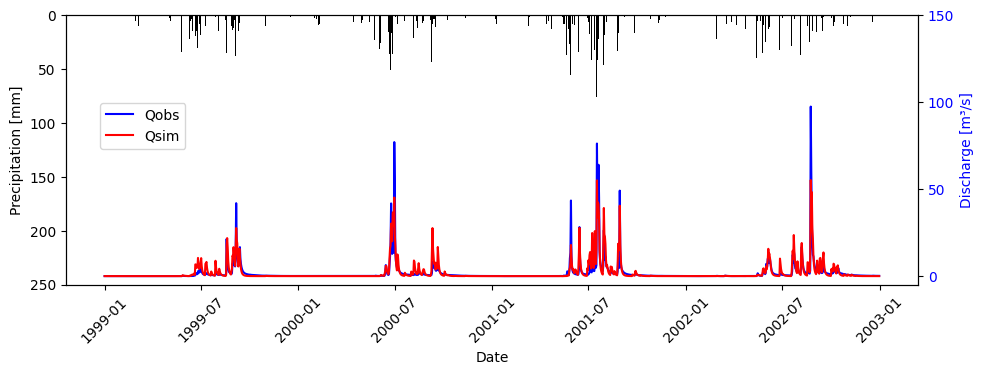

In [27]:
# Create a date range
time1 = np.datetime64('1999-01-01')
time2 = np.datetime64('2002-12-31')
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create a figure and axes with a reduced figure size
fig, ax1 = plt.subplots(figsize=(11., 3.5))

# Plot a histogram for precipitation on ax1
ax1.bar(time, plui, color='black')

# Format x-axis labels
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

ax1.set_xlabel('Date')

# Y-axis settings for precipitation
ax1.set_ylabel('Precipitation [mm]', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(0, 250)
ax1.set_yticks(np.arange(0, 251, 50))

# Invert the y-axis and place ticks on the left for precipitation
ax1.invert_yaxis()
ax1.yaxis.set_label_position("left")

# Create a second y-axis to plot discharges
ax2 = ax1.twinx()
ax2.plot(time, discharge, 'b', label='Qobs')

# Plot minimum, maximum, and mean values as a confidence region
#ax2.fill_between(time, min_trajectory, max_trajectory, color='gray', alpha=0.3, label='95% CrI')

# Plot the mean trajectory
ax2.plot(time, GR4J_HyM, 'red', label='Qsim')

# Y-axis settings for daily discharges
ax2.set_ylabel('Discharge [m³/s]', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(-5, 150)
ax2.set_yticks(np.arange(0, 151, 50))

# Add a legend inside the plot
fig.legend(loc='upper left', bbox_to_anchor=(0.15, 0.65))

# Show the grid
#plt.grid(True)

# Display the plot
plt.show()


Validation

In [28]:
Pn1 = plui1 - etp1
Pn1[Pn1 < 0] = 0

En1 = etp1 - plui1
En1[En1 < 0] = 0

In [29]:
#validation
size = len(discharge1)
Perc1 = Percolation(Pn1, En1, X11)

Qval = np.zeros(size)
Qval[0] = discharge1[0]
for k in range(size-1):

    Qval[k+1] = Qval[k] - (mu1/lambda1) * Qval[k]**(2*mu1-1) +  (1/lambda1) * Perc1[k] * Pn1[k]


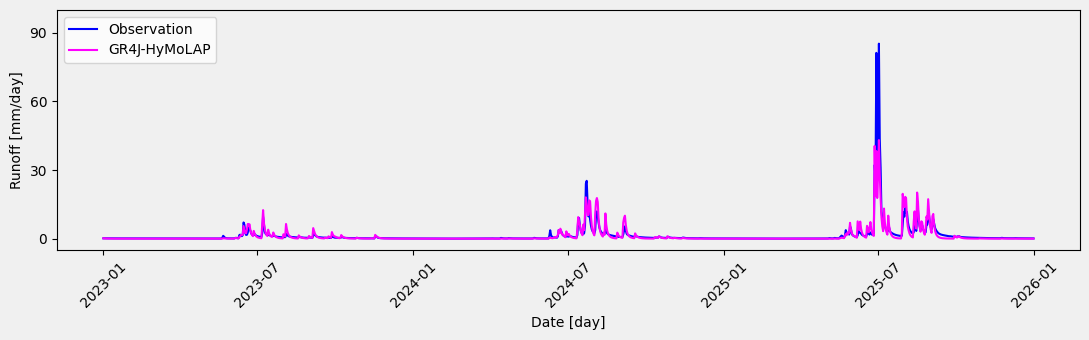

In [30]:
# Generate dates
time1 = np.datetime64('2023-01-01')
time2 = np.datetime64('2025-12-31')
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create a figure and an axis
fig, ax = plt.subplots(figsize=(11., 3.5))

# Background color
fig.patch.set_facecolor('#f0f0f0')
ax.set_facecolor('#f0f0f0')

# Plot observed and simulated runoff
ax.plot(time, discharge1, 'b',  label='Observation', linewidth=1.5)
ax.plot(time, Qval, 'magenta', label='GR4J-HyMoLAP', linewidth=1.5)

# X-axis settings (date format)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 7]))
plt.xticks(rotation=45)
ax.set_xlabel('Date [day]')

# Y-axis settings
ax.set_ylabel('Runoff [mm/day]')
ax.tick_params(axis='y', labelcolor='black')
ax.set_ylim(-5, 100)
ax.set_yticks(np.arange(0, 101, 30))

# Add legend
ax.legend(loc='upper left')

# Show grid
#plt.grid(True)

# Avoid overlap
plt.tight_layout()

# Save figure
plt.savefig("Cauqueness_GR4J-HyMoLAP.jpeg", format='jpeg', dpi=700)

#files.download("Cauqueness_GR4J-HyMoLAP.jpeg")

# Display plot
plt.show()


In [31]:
nse_value = nash_sutcliffe_efficiency(discharge1[1:], Qval[1:])
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

rmse = calculate_rmse(discharge1[1:], Qval[1:])
print('rmse=', rmse)

r2 = calculate_r2(discharge1[1:], Qval[1:])
print('r2=', r2)

Nash-Sutcliffe Efficiency (NSE): 0.7521736716358391
rmse= 2.3357670329673583
r2= 0.759660311239022


HyMoLAP_GR4J_SVM

In [34]:
# Create the training DataFrame with Pe and plui
dataH = pd.DataFrame({
    'Qsim': GR4J_HyM,
    'prec': plui,
    'pet': etp,
    'perc': Perc,
    'target': discharge
})

# Create the test DataFrame with Pe1 and plui1
dataHH = pd.DataFrame({
    'Qsim': Qval,
    'prec': plui1,
    'pet': etp1,
    'perc': Perc1,
    'target': discharge1
})

# Split features and target for the training DataFrame
X_train = dataH[['Qsim', 'prec', 'pet', 'perc']]
y_train = dataH['target']

# Split features and target for the test DataFrame
X_test = dataHH[['Qsim', 'prec', 'pet', 'perc']]
y_test = dataHH['target']


In [35]:
# Setup the pipeline with StandardScaler and SVR
svr_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Normalize data
    ('svr', SVR(kernel= 'rbf'))
])

# Parameter grid for hyperparameter tuning
param_grid = {
    'svr__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'svr__gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
    'svr__epsilon': [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
}

# Repeated K-Fold cross-validation for more robust evaluation
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(svr_pipeline, param_grid, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the model on training data
grid_search.fit(X_train, y_train)

# Best parameters found by GridSearch
best_svr = grid_search.best_estimator_

# Predictions on test data
y_pred_test = best_svr.predict(X_test)

# Predictions on training data
y_pred_train = best_svr.predict(X_train)

# Calculate NSE for train and test (assuming you have a function nash_sutcliffe_efficiency)
nse_train = nash_sutcliffe_efficiency(y_train, y_pred_train)
nse_test  = nash_sutcliffe_efficiency(y_test, y_pred_test)

print(f"NSE on Training Data: {nse_train}")
print(f"NSE on Test Data: {nse_test}")


NSE on Training Data: 0.8454569395236067
NSE on Test Data: 0.7939245293999585


In [36]:
nse_value = nash_sutcliffe_efficiency(discharge[1:], y_pred_train[1:])
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

print('rmse=',calculate_rmse(discharge[1:], y_pred_train[1:]))
print('r2=',calculate_r2(discharge[1:], y_pred_train[1:]))

Nash-Sutcliffe Efficiency (NSE): 0.8454538820288882
rmse= 2.4566608855011625
r2= 0.8470533003304228


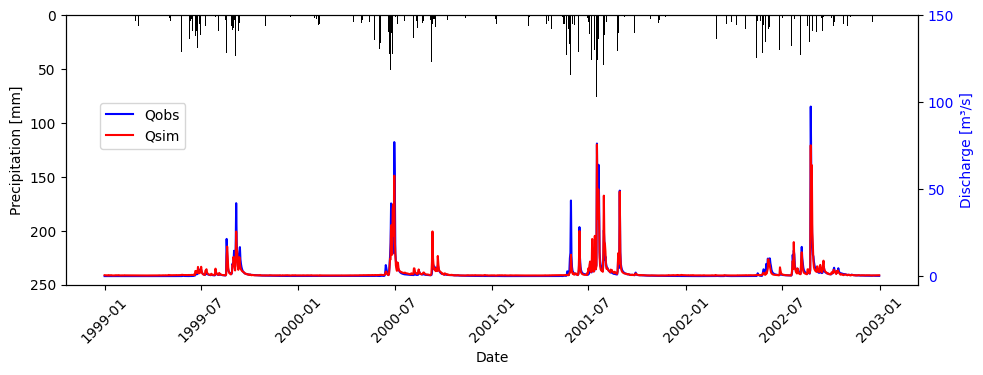

In [37]:
# Create a date range from '01-01-2000' to '12-31-2005'
time1 = np.datetime64('1999-01-01')
time2 = np.datetime64('2002-12-31')
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create a figure and axes with a reduced figure size
fig, ax1 = plt.subplots(figsize=(11., 3.5))

# Plot a histogram for rainfall on ax1
ax1.bar(time, plui, color='black')

# Format the x-axis labels
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

ax1.set_xlabel('Date')

# Y-axis settings for precipitation
ax1.set_ylabel('Precipitation [mm]', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(0, 250)
ax1.set_yticks(np.arange(0, 251, 50))

# Invert the y-axis and place ticks on the left for precipitation
ax1.invert_yaxis()
ax1.yaxis.set_label_position("left")

# Create a second y-axis to plot discharge
ax2 = ax1.twinx()
ax2.plot(time, discharge, 'b', label='Qobs')

# Plot min, max, and mean values as confidence region
#ax2.fill_between(time, min_trajectory, max_trajectory, color='gray', alpha=0.3, label='95% CrI')

# Plot the mean trajectories
ax2.plot(time, y_pred_train, 'red', label='Qsim')

# Y-axis settings for daily discharges
ax2.set_ylabel('Discharge [m³/s]', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(-5, 150)
ax2.set_yticks(np.arange(0, 151, 50))

# Add a legend inside the plot
fig.legend(loc='upper left', bbox_to_anchor=(0.15, 0.65))

# Show grid
#plt.grid(True)

# Display the plot
plt.show()


In [38]:
nse_value = nash_sutcliffe_efficiency(discharge1[1:], y_pred_test[1:])
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

print('rmse=',calculate_rmse(discharge1[1:], y_pred_test[1:]))
print('r2=',calculate_r2(discharge1[1:], y_pred_test[1:]))

Nash-Sutcliffe Efficiency (NSE): 0.7939187096270234
rmse= 2.129977842666771
r2= 0.8545965074256378


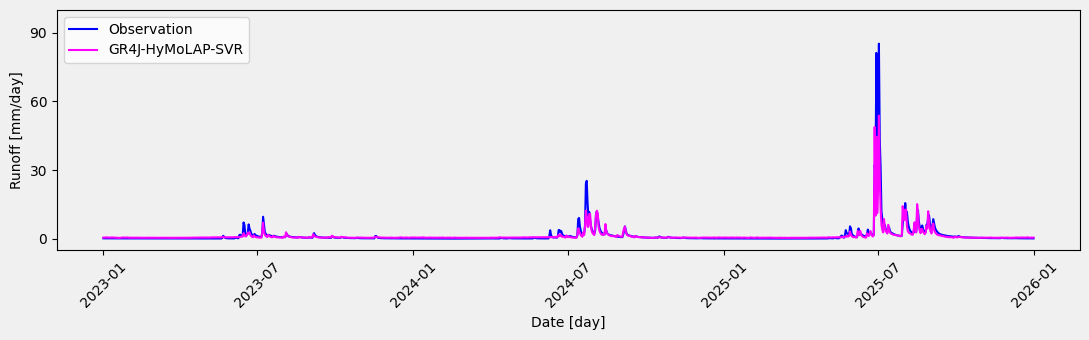

In [39]:
# Generate the dates
time1 = np.datetime64('2023-01-01')
time2 = np.datetime64('2025-12-31')
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create a figure and an axis
fig, ax = plt.subplots(figsize=(11., 3.5))

# Background color
fig.patch.set_facecolor('#f0f0f0')
ax.set_facecolor('#f0f0f0')

# Plot observed and simulated runoff
ax.plot(time, discharge1, 'b',  label='Observation', linewidth=1.5)
ax.plot(time, y_pred_test, 'magenta', label='GR4J-HyMoLAP-SVR', linewidth=1.5)

# X-axis settings (date format)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 7]))
plt.xticks(rotation=45)
ax.set_xlabel('Date [day]')

# Y-axis settings
ax.set_ylabel('Runoff [mm/day]')
ax.tick_params(axis='y', labelcolor='black')
ax.set_ylim(-5, 100)
ax.set_yticks(np.arange(0, 101, 30))

# Add the legend
ax.legend(loc='upper left')

# Avoid overlaps
plt.tight_layout()

# Save the figure
plt.savefig("Cauqueness_GR4J-HyMoLAP-SVR.jpeg", format='jpeg', dpi=700)

#files.download("Cauqueness_GR4J-HyMoLAP-SVR.jpeg")

# Display the plot
plt.show()
